# Context and Defining Problem Statement

The data we have at hand is of passengers and their feedback regarding their flight experience. 

Each row is one passenger. Apart from the  feedback from the customers accross various attributes(15 in total) like food, online_support, cleanliness etc, we have data about the customers' age, loyalty to the airline, gender and class.

The target column is a binary variable which tells us if the customer is satisfied or neutral/dissatisfied

The task at hand is to analyze the data and build a model to predict customer satisfaction using all or some of the data we have.

# Data loading and preprocessing

In [172]:
#Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # Not always recommended, but jsut so our notebook looks clean for this activity
from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Splitting the data for training and testing out model
from sklearn.linear_model import LogisticRegression #importing logistic regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



#### Load data

In [291]:
df1 = pd.read_csv("Flight_data.csv")  # Read the data regarding customer attributes
df2 = pd.read_csv("Survey_data.csv")   # Feedback data from customers

#### Join the two dataframes using the 'id' column as the primary key
- Rename the Id column of one dataframe so that there "id" column name becomes same

In [292]:
#Using pandas' Join method
#c = a.join(b)  # Joining two dfs on the 'Id' column

df = df2.set_index("Id").join(df1.set_index("ID"))


print(df.shape)
df.head()  # the combined dataframe

(90917, 23)


,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
Id,,,,,,,,,,,,,,,,,,,,,
198671,neutral or dissatisfied,poor,acceptable,acceptable,manageable,poor,need improvement,poor,poor,acceptable,...,need improvement,poor,Male,Loyal Customer,30,Business travel,Business,1354,11,8.0
193378,satisfied,excellent,need improvement,excellent,Convinient,acceptable,excellent,acceptable,acceptable,good,...,excellent,acceptable,Female,disloyal Customer,20,NaN,Business,1439,6,0.0
174522,satisfied,good,good,good,manageable,acceptable,excellent,excellent,need improvement,need improvement,...,need improvement,excellent,Female,NaN,55,Personal Travel,Eco Plus,976,4,0.0
191830,satisfied,good,good,good,manageable,poor,good,poor,poor,poor,...,acceptable,poor,Male,disloyal Customer,24,Business travel,Eco,2291,0,0.0
221497,satisfied,good,good,NaN,Convinient,good,good,good,good,good,...,good,good,Male,Loyal Customer,32,Business travel,Business,3974,0,0.0


#### Number of missing values in each of the columns

In [293]:
df.isna().sum() # Since True is 1 and False is 0, if you do a sum of a boolean dataframe, we get the number of trues in each col

Satisfaction                            0
Seat_comfort                            0
Departure.Arrival.time_convenient    8244
Food_drink                           8181
Gate_location                           0
Inflightwifi_service                    0
Inflight_entertainment                  0
Online_support                          0
Ease_of_Onlinebooking                   0
Onboard_service                      7179
Leg_room_service                        0
Baggage_handling                        0
Checkin_service                         0
Cleanliness                             0
Online_boarding                         0
Gender                                  0
CustomerType                         9099
Age                                     0
TypeTravel                           9088
Class                                   0
Flight_Distance                         0
DepartureDelayin_Mins                   0
ArrivalDelayin_Mins                   284
dtype: int64

In [288]:
df.isnull().apply(pd.value_counts)  

,level_0,index,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
False,90917.0,90917.0,90917.0,90917.0,82673,82736,90917.0,90917.0,90917.0,90917.0,...,90917.0,90917.0,90917.0,81818,90917.0,81829,90917.0,90917.0,90917.0,90633
True,NaN,NaN,NaN,NaN,8244,8181,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9099,NaN,9088,NaN,NaN,NaN,284


#### Drop all the rows having atleast one missing values 
- Fill null values in ArrivalDelayin_Mins with mean
- After that drop all the rows with null values

<AxesSubplot:xlabel='ArrivalDelayin_Mins'>

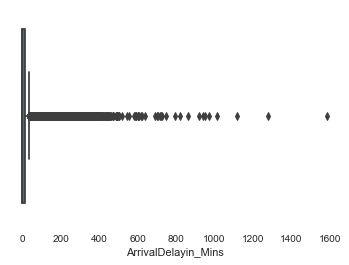

In [289]:
sns.boxplot(df['ArrivalDelayin_Mins'])

In [294]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,90917.0,39.447166,15.129794,7.0,27.0,40.0,51.0,85.0
Flight_Distance,90917.0,1981.629442,1026.779932,50.0,1360.0,1927.0,2542.0,6950.0
DepartureDelayin_Mins,90917.0,14.686593,38.669260,0.0,0.0,0.0,12.0,1592.0
ArrivalDelayin_Mins,90633.0,15.058930,39.038523,0.0,0.0,0.0,13.0,1584.0


In [295]:
# the above two analysis suggest that we are in for many outliers
# so let us use the median to impute the values

df.ArrivalDelayin_Mins.fillna(df.ArrivalDelayin_Mins.median(), inplace = True)



In [296]:
# Rest other missing values are filled with not_captured.
#It can be done in other way also or also can be dropped according to the problem and business context.
df.dropna(inplace = True) 

In [297]:
print(df.shape)

(53798, 23)


# Exploratory Data Analysis

#### correlation

In [302]:
cor = df.corr() # It will show correlation of only numerical variables here.

In [303]:
cor

,Age,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
Age,1.000000,-0.250969,-0.009865,-0.010919
Flight_Distance,-0.250969,1.000000,0.110827,0.108107
DepartureDelayin_Mins,-0.009865,0.110827,1.000000,0.962182
ArrivalDelayin_Mins,-0.010919,0.108107,0.962182,1.000000


In [304]:
to_drop = ['DepartureDelayin_Mins']

### Feedback columns
Seat_comfort', 'Departure.Arrival.time_convenient', 'Food_drink', 'Gate_location',
'Inflightwifi_service', 'Inflight_entertainment', 'Online_support',
'Ease_of_Onlinebooking', 'Onboard_service', 'Leg_room_service',
'Baggage_handling', 'Checkin_service', 'Cleanliness', 'Online_boarding'

#### Manually encode these variables

In [305]:
# Manual label encoding
df.replace({'extremely poor' : 0, 'poor' : 1, 'need improvement' : 2, 'acceptable' : 3, 
            'good' : 4, 'excellent' : 5}, inplace = True)  

df.replace({'very inconvinient' : 0, 'Inconvinient' : 1, 'need improvement' : 2, 'manageable' : 3,
            'Convinient' : 4, 'very convinient' : 5}, inplace = True)

In [306]:
# check for encodings
df['Departure.Arrival.time_convenient'].value_counts()

4    12166
5    11123
3     9656
2     9554
1     8559
0     2740
Name: Departure.Arrival.time_convenient, dtype: int64

####  feedback features with respect to Customer Satisfaction. 



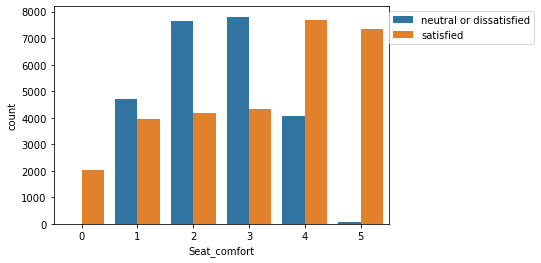

In [21]:
# We can use seaborn's countplot to plot a stacked baatchart
sns.countplot(df.Seat_comfort, hue = df.Satisfaction) 
plt.legend(loc = 'upper right', bbox_to_anchor=(1.45, 1))   # to place the legend in a 'good' position



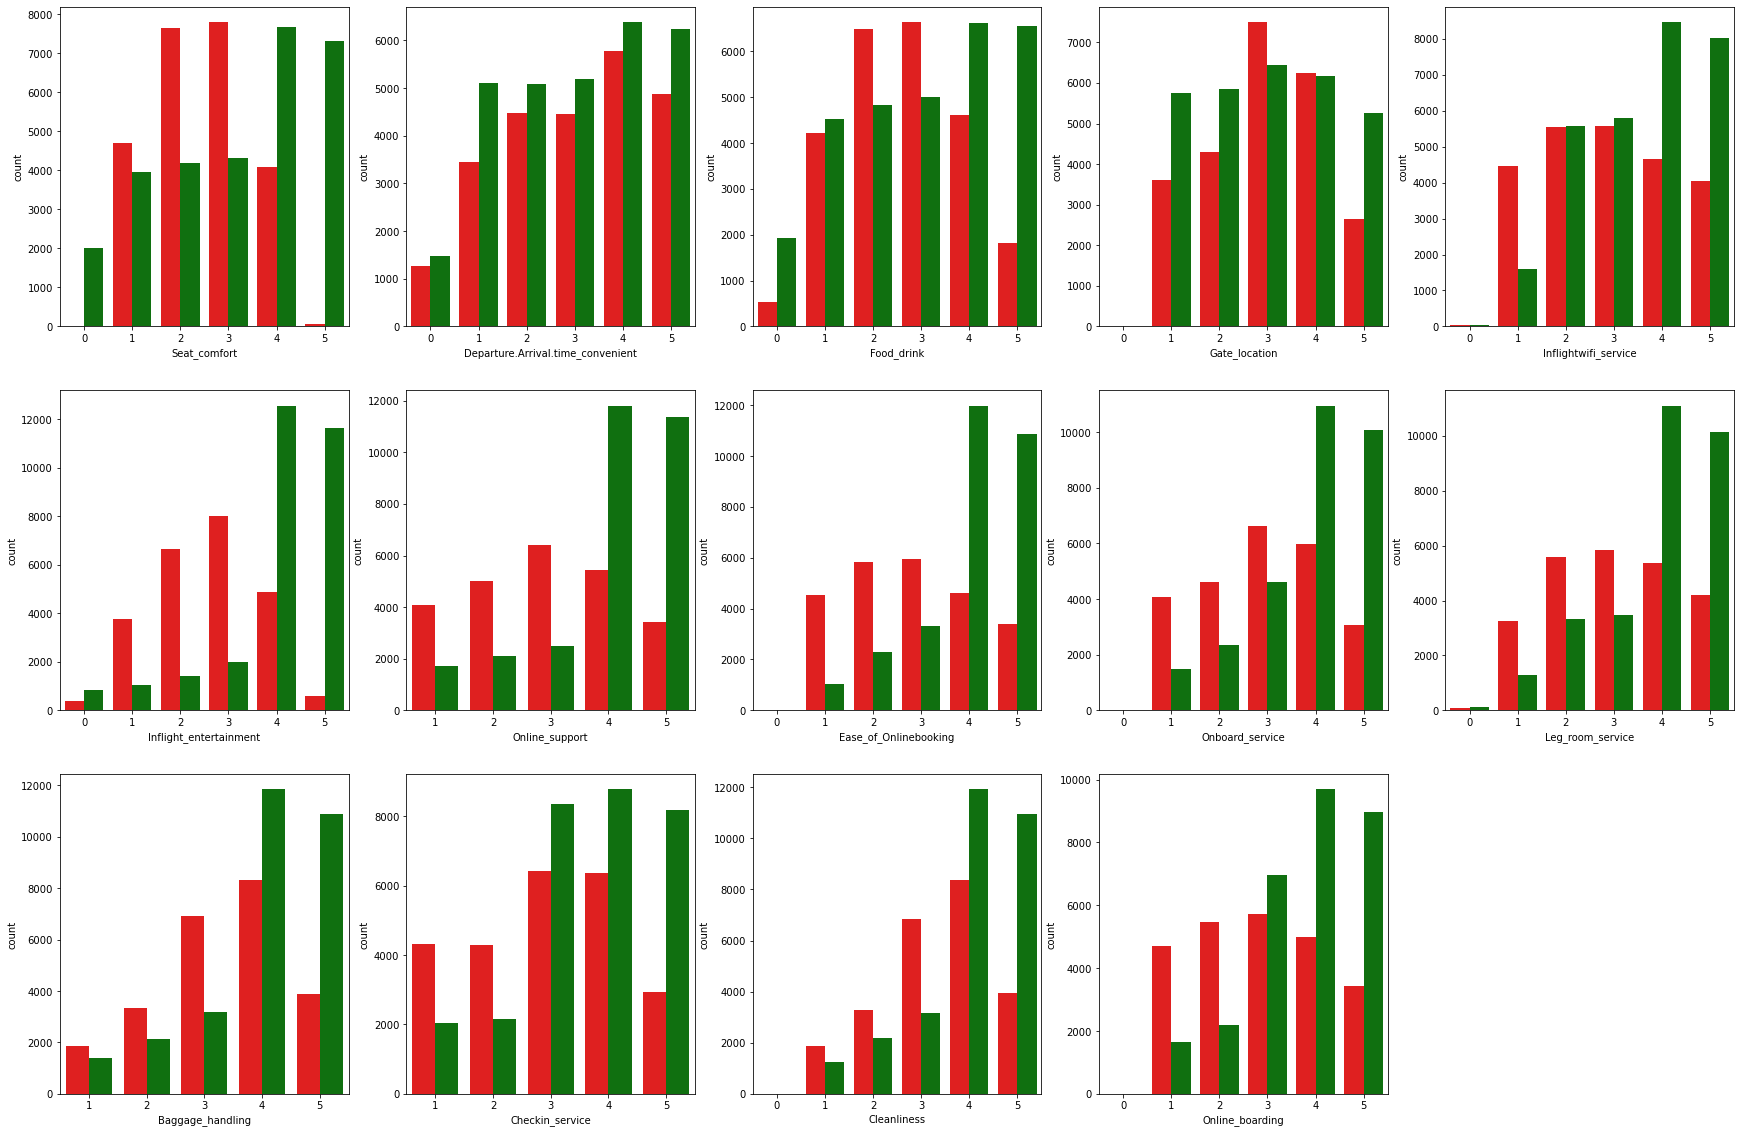

In [22]:
# Since there are a lot of columns that we want to plot, we can put all of them in one plot by using subplot()
# Additionally, since there are a lot of subplots that need to be plotted, we can use a for loop

plt.figure(figsize= (30,20))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
feedback = [ 'Seat_comfort', 'Departure.Arrival.time_convenient', 'Food_drink',
           'Gate_location', 'Inflightwifi_service','Inflight_entertainment',
           'Online_support', 'Ease_of_Onlinebooking', 'Onboard_service',
           'Leg_room_service', 'Baggage_handling','Checkin_service', 'Cleanliness', 'Online_boarding']

for i in feedback:
    plt.subplot(3, 5, pos)
    sns.countplot(df[i], hue = df.Satisfaction,
                  palette = {'satisfied':'green','neutral or dissatisfied': 'red'})
    plt.legend().remove()  # Remove legend to make the entire plot look 'good'
    pos += 1  # to plot over the grid one by one   

#### Average feedback score
- When Satisfaction columns equals 'satisfied'
- When Satisfaction columns is not equal to 'satisfied'

In [183]:
Feedback_cols = ['Seat_comfort', 'Departure.Arrival.time_convenient',
                 'Food_drink', 'Gate_location', 'Inflightwifi_service',
                 'Inflight_entertainment', 'Online_support', 'Ease_of_Onlinebooking', 
                 'Onboard_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service',
                 'Cleanliness', 'Online_boarding']

In [307]:
df.groupby('Satisfaction').mean()*100 # Average rating of individual feedback attributes across satisfaction levels


,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Age,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
Satisfaction,,,,,,,,,,,,,,,,,,
neutral or dissatisfied,246.946832,301.566676,265.968995,300.086352,292.257083,261.819976,296.369094,285.521609,297.257289,306.159793,337.003989,297.150376,338.048439,287.552942,3745.133435,202821.625067,1800.518113,1856.239977
satisfied,314.227077,297.079277,300.115336,297.723803,353.000441,401.557041,398.375114,399.698090,387.591167,385.264086,397.289596,364.110044,398.565080,375.016113,4101.858950,194387.489399,1212.005156,1224.125649


In [ ]:
##??

#### Feature engineering 

AVG ('Ease_of_Onlinebooking', 'Online_boarding', 'Online_support') =  "avg_feedback_of_online_services". 



In [308]:
online_df = df.loc[:, ['Ease_of_Onlinebooking', 'Online_boarding', 'Online_support']]
online_df['avg_feedback_of_online_services'] = online_df.mean(axis = 1)

online_df['avg_feedback_of_online_services'].value_counts()


4.000000    10898
3.000000     7105
5.000000     6522
4.333333     5457
2.000000     5335
3.666667     3799
1.000000     3705
4.666667     3470
3.333333     2565
2.666667     2128
2.333333     1886
1.666667      685
1.333333      241
0.666667        2
Name: avg_feedback_of_online_services, dtype: int64

# Model building and evaluation

#### Encode the columns "Gender", "CustomerType", "TypeTravel", "Class", "Satisfaction" 
- Use manual encoding or other type of encoding

In [309]:
# Number of classes in each of the categorical attributes
for i in df.columns:
    if df[i].dtype == 'O':
        print(i, '->', len(df[i].value_counts()))

Satisfaction -> 2
Gender -> 2
CustomerType -> 2
TypeTravel -> 2
Class -> 3


In [310]:
df.Class.value_counts()

Business    25718
Eco         24156
Eco Plus     3924
Name: Class, dtype: int64

In [311]:
#Manuanl Encoding
df.replace({'Loyal Customer' : 1, 'disloyal Customer' : 0,
               'Business travel' : 1, 'Personal Travel' : 0,
              'Female' : 0, 'Male' : 1,
               'satisfied' : 1, 'neutral or dissatisfied' : 0, 'Eco Plus': 0 , 'Eco': 1, 'Business': 2}, inplace = True)
               

In [312]:
#onehotencoding
df_coded = pd.get_dummies(df)

In [313]:
df_coded

,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
Id,,,,,,,,,,,,,,,,,,,,,
198671,0,1,3,3,3,1,2,1,1,3,...,2,1,1,1,30,1,2,1354,11,8.0
191830,1,4,4,4,3,1,4,1,1,1,...,3,1,1,0,24,1,1,2291,0,0.0
228137,1,5,5,5,5,3,5,5,4,4,...,4,3,1,1,47,1,2,657,0,0.0
240081,1,1,1,1,1,5,5,5,4,2,...,3,5,0,1,30,1,2,5342,140,125.0
233692,1,1,1,1,1,2,5,5,5,5,...,5,3,1,1,58,1,2,351,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240287,1,5,5,5,5,5,4,5,5,5,...,5,4,1,1,78,1,2,2741,0,0.0
177814,1,5,5,5,3,3,5,4,4,4,...,4,3,0,1,67,0,1,306,2,0.0
181405,0,2,0,2,4,3,2,3,3,4,...,4,3,0,0,25,1,2,2070,0,0.0


In [32]:
df_coded.columns

Index(['Satisfaction', 'Seat_comfort', 'Departure.Arrival.time_convenient',
       'Food_drink', 'Gate_location', 'Inflightwifi_service',
       'Inflight_entertainment', 'Online_support', 'Ease_of_Onlinebooking',
       'Onboard_service', 'Leg_room_service', 'Baggage_handling',
       'Checkin_service', 'Cleanliness', 'Online_boarding', 'Gender',
       'CustomerType', 'Age', 'TypeTravel', 'Class', 'Flight_Distance',
       'DepartureDelayin_Mins', 'ArrivalDelayin_Mins'],
      dtype='object')

In [314]:
df_coded.head()

,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
Id,,,,,,,,,,,,,,,,,,,,,
198671,0,1,3,3,3,1,2,1,1,3,...,2,1,1,1,30,1,2,1354,11,8.0
191830,1,4,4,4,3,1,4,1,1,1,...,3,1,1,0,24,1,1,2291,0,0.0
228137,1,5,5,5,5,3,5,5,4,4,...,4,3,1,1,47,1,2,657,0,0.0
240081,1,1,1,1,1,5,5,5,4,2,...,3,5,0,1,30,1,2,5342,140,125.0
233692,1,1,1,1,1,2,5,5,5,5,...,5,3,1,1,58,1,2,351,0,0.0


In [315]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Satisfaction,53798.0,0.547957,0.497699,0.0,0.0,1.0,1.0,1.0
Seat_comfort,53798.0,2.838135,1.394441,0.0,2.0,3.0,4.0,5.0
Departure.Arrival.time_convenient,53798.0,2.991078,1.524952,0.0,2.0,3.0,4.0,5.0
Food_drink,53798.0,2.846797,1.443158,0.0,2.0,3.0,4.0,5.0
Gate_location,53798.0,2.987918,1.305901,0.0,2.0,3.0,4.0,5.0
Inflightwifi_service,53798.0,3.255418,1.320235,0.0,2.0,3.0,4.0,5.0
Inflight_entertainment,53798.0,3.383899,1.340946,0.0,2.0,4.0,4.0,5.0
Online_support,53798.0,3.522640,1.307606,1.0,3.0,4.0,5.0,5.0
Ease_of_Onlinebooking,53798.0,3.480854,1.305044,0.0,2.0,4.0,5.0,5.0
Onboard_service,53798.0,3.467564,1.270305,0.0,3.0,4.0,4.0,5.0


# Scaling

In [316]:
df_coded.columns

Index(['Satisfaction', 'Seat_comfort', 'Departure.Arrival.time_convenient',
       'Food_drink', 'Gate_location', 'Inflightwifi_service',
       'Inflight_entertainment', 'Online_support', 'Ease_of_Onlinebooking',
       'Onboard_service', 'Leg_room_service', 'Baggage_handling',
       'Checkin_service', 'Cleanliness', 'Online_boarding', 'Gender',
       'CustomerType', 'Age', 'TypeTravel', 'Class', 'Flight_Distance',
       'DepartureDelayin_Mins', 'ArrivalDelayin_Mins'],
      dtype='object')

In [317]:
#Here we are going to use StandardScaler to scale our data.


scaler = StandardScaler()
#What all columns to scale? I have preferred all columns except onehotencoded columns and target columns as
#scaling of target feature will not change anything as they already have values like 0 and 1 only.
#You may only scale numerical features and leave categorical features as required according to business problem need and results.
cols_to_scale = ['Seat_comfort', 'Departure.Arrival.time_convenient',
       'Food_drink', 'Gate_location', 'Inflightwifi_service',
       'Inflight_entertainment', 'Online_support', 'Ease_of_Onlinebooking',
       'Onboard_service', 'Leg_room_service', 'Baggage_handling',
       'Checkin_service', 'Cleanliness', 'Online_boarding',
       'Age', 'Flight_Distance','DepartureDelayin_Mins', 'ArrivalDelayin_Mins']

df_coded[cols_to_scale] = scaler.fit_transform(df_coded[cols_to_scale].to_numpy())

In [320]:
df_coded.describe()

,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
count,53798.000000,5.379800e+04,5.379800e+04,5.379800e+04,5.379800e+04,5.379800e+04,5.379800e+04,5.379800e+04,5.379800e+04,5.379800e+04,...,5.379800e+04,5.379800e+04,53798.000000,53798.000000,5.379800e+04,53798.000000,53798.000000,5.379800e+04,5.379800e+04,5.379800e+04
mean,0.547957,2.008678e-16,-1.487610e-16,2.650147e-16,9.794023e-17,1.889719e-16,2.613857e-16,-5.318001e-16,1.839324e-16,4.397224e-16,...,-2.595790e-16,3.706033e-16,0.489814,0.818451,-5.707852e-17,0.689319,1.405108,2.020660e-17,6.200083e-16,1.081309e-15
std,0.497699,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,...,1.000009e+00,1.000009e+00,0.499901,0.385476,1.000009e+00,0.462777,0.621998,1.000009e+00,1.000009e+00,1.000009e+00
min,0.000000,-2.035339e+00,-1.961443e+00,-1.972635e+00,-2.288034e+00,-2.465810e+00,-2.523540e+00,-1.929223e+00,-2.667257e+00,-2.729734e+00,...,-3.239864e+00,-2.583956e+00,0.000000,0.000000,-2.148191e+00,0.000000,0.000000,-1.879567e+00,-3.810895e-01,-3.859077e-01
25%,0.000000,-6.010601e-01,-6.499137e-01,-5.867723e-01,-7.565100e-01,-9.509140e-01,-1.032041e+00,-3.996961e-01,-1.134727e+00,-3.680755e-01,...,-6.215026e-01,-1.043499e+00,0.000000,1.000000,-8.223941e-01,0.000000,1.000000,-6.060927e-01,-3.810895e-01,-3.859077e-01
50%,1.000000,1.160796e-01,5.850905e-03,1.061589e-01,9.252117e-03,-1.934661e-01,4.594568e-01,3.650673e-01,3.978032e-01,4.191442e-01,...,2.512844e-01,4.969593e-01,0.000000,1.000000,3.937368e-02,1.000000,1.000000,-5.302166e-02,-3.810895e-01,-3.859077e-01
75%,1.000000,8.332193e-01,6.616155e-01,7.990901e-01,7.750142e-01,5.639817e-01,4.594568e-01,1.129831e+00,1.164068e+00,4.191442e-01,...,1.124071e+00,4.969593e-01,1.000000,1.000000,7.685618e-01,1.000000,2.000000,5.428552e-01,-7.168788e-02,-5.364032e-02
max,1.000000,1.550359e+00,1.317380e+00,1.492021e+00,1.540776e+00,1.321430e+00,1.205206e+00,1.129831e+00,1.164068e+00,1.206364e+00,...,1.124071e+00,1.267188e+00,1.000000,1.000000,3.022416e+00,1.000000,2.000000,4.833169e+00,2.870266e+01,2.811241e+01


In [321]:
df_coded.head()

,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
Id,,,,,,,,,,,,,,,,,,,,,
198671,0,-1.318200,0.005851,0.106159,0.009252,-1.708362,-1.032041,-1.929223,-1.900992,-0.368075,...,-1.494290,-1.813728,1,1,-0.623525,1,2,-0.610957,-0.097471,-0.181435
191830,1,0.833219,0.661615,0.799090,0.009252,-1.708362,0.459457,-1.929223,-1.900992,-1.942515,...,-0.621503,-1.813728,1,0,-1.021264,1,1,0.300613,-0.381089,-0.385908
228137,1,1.550359,1.317380,1.492021,1.540776,-0.193466,1.205206,1.129831,0.397803,0.419144,...,0.251284,-0.273270,1,1,0.503402,1,2,-1.289040,-0.381089,-0.385908
240081,1,-1.318200,-1.305678,-1.279703,-1.522272,1.321430,1.205206,1.129831,0.397803,-1.155295,...,-0.621503,1.267188,0,1,-0.623525,1,2,3.268809,3.228596,2.808971
233692,1,-1.318200,-1.305678,-1.279703,-1.522272,-0.950914,1.205206,1.129831,1.164068,1.206364,...,1.124071,-0.273270,1,1,1.232591,1,2,-1.586736,-0.381089,-0.385908


In [322]:
df = df_coded

In [323]:
df.head()

,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
Id,,,,,,,,,,,,,,,,,,,,,
198671,0,-1.318200,0.005851,0.106159,0.009252,-1.708362,-1.032041,-1.929223,-1.900992,-0.368075,...,-1.494290,-1.813728,1,1,-0.623525,1,2,-0.610957,-0.097471,-0.181435
191830,1,0.833219,0.661615,0.799090,0.009252,-1.708362,0.459457,-1.929223,-1.900992,-1.942515,...,-0.621503,-1.813728,1,0,-1.021264,1,1,0.300613,-0.381089,-0.385908
228137,1,1.550359,1.317380,1.492021,1.540776,-0.193466,1.205206,1.129831,0.397803,0.419144,...,0.251284,-0.273270,1,1,0.503402,1,2,-1.289040,-0.381089,-0.385908
240081,1,-1.318200,-1.305678,-1.279703,-1.522272,1.321430,1.205206,1.129831,0.397803,-1.155295,...,-0.621503,1.267188,0,1,-0.623525,1,2,3.268809,3.228596,2.808971
233692,1,-1.318200,-1.305678,-1.279703,-1.522272,-0.950914,1.205206,1.129831,1.164068,1.206364,...,1.124071,-0.273270,1,1,1.232591,1,2,-1.586736,-0.381089,-0.385908


In [324]:
df['Seat_comfort'].head()

Id
198671   -1.318200
191830    0.833219
228137    1.550359
240081   -1.318200
233692   -1.318200
Name: Seat_comfort, dtype: float64

In [329]:
df.iloc[:,1]

Id
198671   -1.318200
191830    0.833219
228137    1.550359
240081   -1.318200
233692   -1.318200
            ...   
240287    1.550359
177814    1.550359
181405   -0.601060
224128    0.833219
186039    0.116080
Name: Seat_comfort, Length: 53798, dtype: float64

### 15. Seperate the column "Satisfaction" from the rest of the columns
- Create X and y

In [330]:
#We are going to drop highly correlated feature which we have found before as there features might affect our models.
to_drop 

['DepartureDelayin_Mins']

In [331]:
X = df.drop(columns= ['Satisfaction', 'DepartureDelayin_Mins'])  # Seperating the target and the rest
#X = df.drop(columns= ['Satisfaction'])
y = df.Satisfaction

In [332]:
X.head()

,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,Leg_room_service,...,Checkin_service,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,ArrivalDelayin_Mins
Id,,,,,,,,,,,,,,,,,,,,,
198671,-1.318200,0.005851,0.106159,0.009252,-1.708362,-1.032041,-1.929223,-1.900992,-0.368075,-0.383591,...,-1.062575,-1.494290,-1.813728,1,1,-0.623525,1,2,-0.610957,-0.181435
191830,0.833219,0.661615,0.799090,0.009252,-1.708362,0.459457,-1.929223,-1.900992,-1.942515,0.391253,...,-0.268669,-0.621503,-1.813728,1,0,-1.021264,1,1,0.300613,-0.385908
228137,1.550359,1.317380,1.492021,1.540776,-0.193466,1.205206,1.129831,0.397803,0.419144,1.166097,...,-0.268669,0.251284,-0.273270,1,1,0.503402,1,2,-1.289040,-0.385908
240081,-1.318200,-1.305678,-1.279703,-1.522272,1.321430,1.205206,1.129831,0.397803,-1.155295,0.391253,...,1.319143,-0.621503,1.267188,0,1,-0.623525,1,2,3.268809,2.808971
233692,-1.318200,-1.305678,-1.279703,-1.522272,-0.950914,1.205206,1.129831,1.164068,1.206364,1.166097,...,1.319143,1.124071,-0.273270,1,1,1.232591,1,2,-1.586736,-0.385908


In [337]:
X

,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,Leg_room_service,...,Checkin_service,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,ArrivalDelayin_Mins
Id,,,,,,,,,,,,,,,,,,,,,
198671,-1.318200,0.005851,0.106159,0.009252,-1.708362,-1.032041,-1.929223,-1.900992,-0.368075,-0.383591,...,-1.062575,-1.494290,-1.813728,1,1,-0.623525,1,2,-0.610957,-0.181435
191830,0.833219,0.661615,0.799090,0.009252,-1.708362,0.459457,-1.929223,-1.900992,-1.942515,0.391253,...,-0.268669,-0.621503,-1.813728,1,0,-1.021264,1,1,0.300613,-0.385908
228137,1.550359,1.317380,1.492021,1.540776,-0.193466,1.205206,1.129831,0.397803,0.419144,1.166097,...,-0.268669,0.251284,-0.273270,1,1,0.503402,1,2,-1.289040,-0.385908
240081,-1.318200,-1.305678,-1.279703,-1.522272,1.321430,1.205206,1.129831,0.397803,-1.155295,0.391253,...,1.319143,-0.621503,1.267188,0,1,-0.623525,1,2,3.268809,2.808971
233692,-1.318200,-1.305678,-1.279703,-1.522272,-0.950914,1.205206,1.129831,1.164068,1.206364,1.166097,...,1.319143,1.124071,-0.273270,1,1,1.232591,1,2,-1.586736,-0.385908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240287,1.550359,1.317380,1.492021,1.540776,1.321430,0.459457,1.129831,1.164068,1.206364,1.166097,...,-0.268669,1.124071,0.496959,1,1,2.558387,1,2,0.738400,-0.385908
177814,1.550359,1.317380,1.492021,0.009252,-0.193466,1.205206,0.365067,0.397803,0.419144,1.166097,...,1.319143,0.251284,-0.273270,0,1,1.829199,0,1,-1.630514,-0.385908
181405,-0.601060,-1.961443,-0.586772,0.775014,-0.193466,-1.032041,-0.399696,-0.368462,0.419144,-1.158434,...,1.319143,0.251284,-0.273270,0,0,-0.954974,1,2,0.085611,-0.385908


### 16. Create train and test datasets
- Use train_test_split

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1, stratify = y)

In [339]:
y_train.value_counts()

1    22109
0    18239
Name: Satisfaction, dtype: int64

In [340]:
y_test.value_counts()

1    7370
0    6080
Name: Satisfaction, dtype: int64

In [341]:
X_train.dtypes

Seat_comfort                         float64
Departure.Arrival.time_convenient    float64
Food_drink                           float64
Gate_location                        float64
Inflightwifi_service                 float64
Inflight_entertainment               float64
Online_support                       float64
Ease_of_Onlinebooking                float64
Onboard_service                      float64
Leg_room_service                     float64
Baggage_handling                     float64
Checkin_service                      float64
Cleanliness                          float64
Online_boarding                      float64
Gender                                 int64
CustomerType                           int64
Age                                  float64
TypeTravel                             int64
Class                                  int64
Flight_Distance                      float64
ArrivalDelayin_Mins                  float64
dtype: object

### 17. Print accuracy
- Print accuracy on test data using below models
- Logistic regression model trained using all the attributes
- Logistic regression model trained using only the feedback columns
- Decision tree model trained using all the attributes
- Random forest model trained using all the attributes

Logistic Regression

In [342]:
def evaluate_model(model,features):
    
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train[features])[:,1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test[features])[:,1])
    recall_train = recall_score(y_train, model.predict(X_train[features]))
    recall_test = recall_score(y_test, model.predict(X_test[features]))
    
    return auc_train, auc_test, recall_train ,recall_test

In [343]:
#Logistic Regression with only feedback columns


lr = LogisticRegression(random_state=5)

lr.fit(X_train, y_train)

pred = lr.predict(X_test)  # Predictions from logistic regression
score1 = lr.score(X_test, y_test)
score1

0.8359851301115242

In [344]:
scores_1 = evaluate_model(lr,X_train.columns)
print(' AUC Train', scores_1[0])
print(' AUC Test', scores_1[1])
print(' Recall Train', scores_1[2])
print(' Recall Test', scores_1[3])

result_df = pd.DataFrame({
    'Method' : ['LR'],
    'AUC Train ' : [scores_1[0]],
    'AUC Test ' : [scores_1[1]],
    ' Recall Train ' : [scores_1[2]],
    ' Recall Test ' : [scores_1[3]],    
    
})


 AUC Train 0.9090242374128048
 AUC Test 0.9107778690280655
 Recall Train 0.8500610611063368
 Recall Test 0.8550881953867029


Predicting customer satisfaction solely based on the feedback

In [345]:
feedback

['Seat_comfort',
 'Departure.Arrival.time_convenient',
 'Food_drink',
 'Gate_location',
 'Inflightwifi_service',
 'Inflight_entertainment',
 'Online_support',
 'Ease_of_Onlinebooking',
 'Onboard_service',
 'Leg_room_service',
 'Baggage_handling',
 'Checkin_service',
 'Cleanliness',
 'Online_boarding']

In [346]:
%%time
#Logistic Regression with only feedback columns
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,feedback], y, random_state = 1, stratify = y)

lr = LogisticRegression(random_state=5)

lr.fit(X_train, y_train)

pred = lr.predict(X_test)

score2 = lr.score(X_test, y_test)

print(f'Number of features used = {len(X_train.columns)}')
print(f'Accuracy in predicting customer satisfaction solely based on the feedback = {score2}')

Number of features used = 14
Accuracy in predicting customer satisfaction solely based on the feedback = 0.8050557620817844
Wall time: 145 ms


In [347]:
y_train.value_counts()

1    22109
0    18239
Name: Satisfaction, dtype: int64

In [348]:
recall_score(y_test,pred)

0.8550881953867029

In [209]:
X_train.columns

Index(['Seat_comfort', 'Departure.Arrival.time_convenient', 'Food_drink',
       'Gate_location', 'Inflightwifi_service', 'Inflight_entertainment',
       'Online_support', 'Ease_of_Onlinebooking', 'Onboard_service',
       'Leg_room_service', 'Baggage_handling', 'Checkin_service',
       'Cleanliness', 'Online_boarding', 'Gender', 'CustomerType', 'Age',
       'TypeTravel', 'Class', 'Flight_Distance', 'ArrivalDelayin_Mins'],
      dtype='object')

In [349]:
recall_score(y_train, lr.predict(X_train))

0.8500610611063368

In [350]:
scores_2 = evaluate_model(lr,X_train.columns)
print(' AUC Train', scores_2[0])
print(' AUC Test', scores_2[1])
print(' Recall Train', scores_2[2])
print(' Recall Test', scores_2[3])

result_df.loc[1] = ['LR with only feedback columns', scores_2[0],scores_2[1], scores_2[2],scores_2[3]]

 AUC Train 0.9090242374128048
 AUC Test 0.9107778690280655
 Recall Train 0.8500610611063368
 Recall Test 0.8550881953867029


Decision Tree

In [351]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt = DecisionTreeClassifier(random_state=5)

dt.fit(X_train, y_train)

score3 = dt.score(X_test, y_test)
pred = dt.predict(X_test)

print(f"Decision tree acccuracy score: {score3}")

Decision tree acccuracy score: 0.9310780669144981
Wall time: 348 ms


In [352]:
scores_3 = evaluate_model(dt,X_train.columns)
print(' AUC Train', scores_3[0])
print(' AUC Test', scores_3[1])
print(' Recall Train', scores_3[2])
print(' Recall Test', scores_3[3])


result_df.loc[2] = ['DT', scores_3[0],scores_3[1], scores_3[2],scores_3[3]]

 AUC Train 0.9824124043312703
 AUC Test 0.984013470327787
 Recall Train 0.9841241123524357
 Recall Test 0.9848032564450475


Random Forest

In [353]:
%%time

rf = RandomForestClassifier(random_state=5)

rf.fit(X_train, y_train)

score4 = rf.score(X_test, y_test)

print(f'Random Forest accuracy score = {score4}')

Random Forest accuracy score = 0.9528624535315985
Wall time: 6.3 s


In [354]:
scores_4 = evaluate_model(rf,X_train.columns)
print(' AUC Train', scores_4[0])
print(' AUC Test', scores_4[1])
print(' Recall Train', scores_4[2])
print(' Recall Test', scores_4[3])

result_df.loc[3] = ['Random Forest', scores_4[0],scores_4[1], scores_4[2],scores_4[3]]

 AUC Train 0.998980099125633
 AUC Test 0.9988660019281583
 Recall Train 0.9879687005291963
 Recall Test 0.9865671641791045


In [355]:
result_df

,Method,AUC Train,AUC Test,Recall Train,Recall Test
0,LR,0.909024,0.910778,0.850061,0.855088
1,LR with only feedback columns,0.909024,0.910778,0.850061,0.855088
2,DT,0.982412,0.984013,0.984124,0.984803
3,Random Forest,0.998980,0.998866,0.987969,0.986567


### 18. Print feature importance
- Print feature importance of Random Forest



In [356]:
#Decision Tree 
pd.Series(dt.feature_importances_, X_train.columns ).sort_values(ascending= False)

Inflight_entertainment               0.386919
Seat_comfort                         0.180435
Ease_of_Onlinebooking                0.069417
CustomerType                         0.049522
TypeTravel                           0.037292
Flight_Distance                      0.031254
Age                                  0.027360
Class                                0.022666
Gate_location                        0.021287
Departure.Arrival.time_convenient    0.021049
Online_support                       0.020004
Checkin_service                      0.018955
ArrivalDelayin_Mins                  0.016719
Baggage_handling                     0.016358
Leg_room_service                     0.015902
Gender                               0.015645
Cleanliness                          0.013259
Onboard_service                      0.011280
Online_boarding                      0.008706
Food_drink                           0.008051
Inflightwifi_service                 0.007920
dtype: float64

In [357]:
#RandomForest
pd.Series(rf.feature_importances_, X_train.columns).sort_values(ascending= False)
## Alternate Way
##pd.DataFrame({'Attribute': X_train.columns, 'Importance': rf.feature_importances_}) 

Inflight_entertainment               0.195455
Seat_comfort                         0.127600
Ease_of_Onlinebooking                0.078325
Online_support                       0.067963
CustomerType                         0.043138
Onboard_service                      0.042764
Food_drink                           0.042584
Leg_room_service                     0.041980
Flight_Distance                      0.039574
Class                                0.034088
Online_boarding                      0.033973
Age                                  0.033438
Gender                               0.029036
Baggage_handling                     0.027363
Cleanliness                          0.027302
TypeTravel                           0.026838
Checkin_service                      0.026438
Departure.Arrival.time_convenient    0.023285
Gate_location                        0.020571
ArrivalDelayin_Mins                  0.020013
Inflightwifi_service                 0.018272
dtype: float64

# Model Tuning

### 19. Print cross validation score
- Decision tree model trained using all the attributes
- Random Forest model trained using all the attributes
- Fine tuned (using Grid Search or Random Search) Random Forest model

**Display all the scores above with their respective models in a single dataframe**



Cross Validation Score

In [358]:
%%time
#For Decision Tree dt
score5 = cross_val_score(dt, X, y, cv = 10).mean()
print(f'Cross validation score of Decision tree = {score5}')

Cross validation score of Decision tree = 0.9365216479341733
Wall time: 4.46 s


In [359]:
%%time
#Random Forest rf
score6 = cross_val_score(rf, X, y, cv = 10).mean()
print(f'Cross validation score of Random forest = {score6}')

Cross validation score of Random forest = 0.9547008848260929
Wall time: 1min 8s


Parameter Tuning Using GridDSearch

Doing it only for RandomForest as the mean CV score is better.

In [248]:
%%time
parameters = {'bootstrap': [True,False],
 'max_depth': [10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8],
 'n_estimators': [100]}


# clf_gscv = GridSearchCV(RandomForestClassifier(random_state=5), parameters, cv = 5, verbose = 2, n_jobs= 7)
# clf_gscv.fit(X, y)

# print(clf_gscv.best_params_)


# Best parameters
#{'bootstrap': True,
# 'max_depth': 30,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 1,
#  'n_estimators': 100} 
scores_5 = evaluate_model(clf_gscv.best_estimator_,X_train.columns)
print(' AUC Train', scores_5[0])
print(' AUC Test', scores_5[1])
print(' Recall Train', scores_5[2])
print(' Recall Test', scores_5[3])
result_df.loc[4] = ['Random Forest GridSearchcv', scores_5[0],scores_5[1], scores_5[2],scores_5[3]]

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   60.0s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  5.4min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed: 14.5min
[Parallel(n_jobs=7)]: Done 400 out of 400 | elapsed: 16.8min finished


{'bootstrap': False, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}
 AUC Train 1.0
 AUC Test 0.9999999999999999
 Recall Train 1.0
 Recall Test 1.0
Wall time: 17min 5s


In [249]:
# result_df

,Method,AUC Train,AUC Test,Recall Train,Recall Test
0,LR,0.910107,0.906980,0.848896,0.850296
1,LR with only feedback columns,0.910107,0.906980,0.848896,0.850296
2,DT,1.000000,0.931139,1.000000,0.937668
3,Random Forest,1.000000,0.991183,1.000000,0.950862
4,Random Forest GridSearchcv,1.000000,1.000000,1.000000,1.000000


In [226]:
%%time
rf = RandomForestClassifier(bootstrap= True,
 max_depth= 30,
 max_features= 'auto',
 min_samples_leaf= 1,
 n_estimators= 100)


score7 = cross_val_score(rf, X, y, cv = 5).mean()


score7
    

Wall time: 27.5 s


In [361]:
np.arange(1,20,1),np.arange(0.1,0.8,0.1)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]))

In [227]:
%%time

parameters = {
  'bootstrap': [True],
 'max_depth': np.arange(1,20,1),
 'max_features': np.arange(0.1,0.8,0.1),
 'n_estimators': np.arange(10,150,10)}


clf_rf = RandomizedSearchCV(RandomForestClassifier(random_state=5), parameters, n_iter = 30, random_state= 1, cv = 5, verbose = 2, n_jobs= 4)
clf_rf.fit(X, y)

print(clf_rf.best_params_)

scores_6 = evaluate_model(clf_rf.best_estimator_,X_train.columns)
print(' AUC Train', scores_6[0])
print(' AUC Test', scores_6[1])
print(' Recall Train', scores_6[2])
print(' Recall Test', scores_6[3])
result_df.loc[5] = ['Random Forest Randomize Searchcv', scores_6[0],scores_6[1], scores_6[2],scores_6[3]]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  4.7min finished


{'n_estimators': 130, 'max_features': 0.5, 'max_depth': 18, 'bootstrap': True}
Wall time: 4min 55s


In [ ]:
# fit ## learn from data , training , cal average - train
# transform ## apply on new data what you learn from fit - test
# fit_transform ## learn from data and apply on same data  Learn from same data, apply on same data 
# predict## predictions using model 
# predict_proba ## 


In [ ]:
# fit(train)
# transform(test)
# ##
# fit(train)
# transform(train)
# ##
# fit_transform(train)

In [ ]:
# 1. fit
# 2. transform
# fit_transform
# inverse_transform  = label encoding 0,1,2,3

In [362]:
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [363]:
%%time
def rf_bo(max_depth, n_estimators, max_features):
    rf = RandomForestClassifier(random_state=5, 
                                n_estimators = int(n_estimators),
                                max_depth = int(max_depth),
                                max_features = float(max_features))
    rf.fit(X_train,y_train)
    return -log_loss(y_test,rf.predict_proba(X_test)[:,1])

# set parameters
parameters = {'max_depth':(1,30),
              'n_estimators':(10,150),
              'max_features':(0.1,0.6)}
Bo = BayesianOptimization(rf_bo, parameters, random_state=1)

Bo.maximize(init_points=2)
Bo.max

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        | -0.1354   |  13.09    |  0.4602   |  10.02    |
|  2        | -0.2226   |  9.768    |  0.1734   |  22.93    |
|  3        | -0.161    |  13.02    |  0.213    |  10.16    |
|  4        | -0.1345   |  14.47    |  0.5875   |  10.21    |
|  5        | -0.1345   |  14.96    |  0.5765   |  10.02    |
|  6        | -0.1385   |  15.2     |  0.4515   |  10.95    |
|  7        | -0.1334   |  14.64    |  0.5882   |  11.88    |
|  8        | -0.1544   |  15.35    |  0.1554   |  12.44    |
|  9        | -0.1284   |  28.71    |  0.432    |  75.9     |
|  10       | -0.119    |  15.17    |  0.5206   |  147.1    |
|  11       | -0.1507   |  10.35    |  0.4818   |  130.0    |
|  12       | -0.1158   |  25.79    |  0.4597   |  137.7    |
|  13       | -0.1243   |  20.64    |  0.374    |  63.65    |
|  14       | -0.3301   |  5.082    |  0.1697   |  54.36    |
|  15   

In [364]:
clf_bo = RandomForestClassifier(random_state=5, max_depth=10, max_features=0.6,n_estimators=78)
clf_bo.fit(X, y)
scores_8 = evaluate_model(clf_bo,X_train.columns)
print(' AUC Train', scores_8[0])
print(' AUC Test', scores_8[1])
print(' Recall Train', scores_8[2])
print(' Recall Test', scores_8[3])
result_df.loc[6] = ['Random Forest BO', scores_8[0],scores_8[1], scores_8[2],scores_8[3]]

 AUC Train 0.9919818148448527
 AUC Test 0.9924892210597729
 Recall Train 0.9542267854719797
 Recall Test 0.9538670284938942


In [365]:
result_df

,Method,AUC Train,AUC Test,Recall Train,Recall Test
0,LR,0.909024,0.910778,0.850061,0.855088
1,LR with only feedback columns,0.909024,0.910778,0.850061,0.855088
2,DT,0.982412,0.984013,0.984124,0.984803
3,Random Forest,0.998980,0.998866,0.987969,0.986567
6,Random Forest BO,0.991982,0.992489,0.954227,0.953867


# Pipeline - Automate and Simplify the process

In [233]:
#!pip install category_encoders

In [250]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import OrdinalEncoder

from sklearn.metrics import recall_score, roc_auc_score

numeric_features = ['Age', 'Flight_Distance', 'DepartureDelayin_Mins'
       ]

feedback_features = ['Seat_comfort', 'Departure.Arrival.time_convenient', 'Food_drink',
       'Gate_location', 'Inflightwifi_service', 'Inflight_entertainment',
       'Online_support', 'Ease_of_Onlinebooking', 'Onboard_service',
       'Leg_room_service', 'Baggage_handling', 'Checkin_service',
       'Cleanliness', 'Online_boarding']

other_cat_cols =  ['Gender', 'CustomerType', 'TypeTravel', 'Class']


#TRANSFORMERS



numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


feedback_feature_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='not_captured')),
    ('label_encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())])


other_cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='not_captured')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('feed_col', feedback_feature_transformer, feedback_features),
        ('other_cat_col', other_cat_transformer, other_cat_cols )
    ])

In [251]:
#Adding into Pipeline
clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(bootstrap= True,max_depth= 30,max_features= 'auto',min_samples_leaf= 1,n_estimators= 100))])

In [252]:
df2 = df2.reset_index()

In [253]:
df2.set_index('Id')

,level_0,index,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding
Id,,,,,,,,,,,,,,,,,
198671,0,0,neutral or dissatisfied,poor,acceptable,acceptable,manageable,poor,need improvement,poor,poor,acceptable,acceptable,poor,need improvement,need improvement,poor
193378,1,1,satisfied,excellent,need improvement,excellent,Convinient,acceptable,excellent,acceptable,acceptable,good,acceptable,excellent,acceptable,excellent,acceptable
174522,2,2,satisfied,good,good,good,manageable,acceptable,excellent,excellent,need improvement,need improvement,good,need improvement,excellent,need improvement,excellent
191830,3,3,satisfied,good,good,good,manageable,poor,good,poor,poor,poor,good,poor,acceptable,acceptable,poor
221497,4,4,satisfied,good,good,NaN,Convinient,good,good,good,good,good,good,good,excellent,good,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152951,90912,90912,satisfied,extremely poor,good,extremely poor,Convinient,need improvement,excellent,good,good,good,excellent,excellent,good,good,acceptable
220134,90913,90913,satisfied,poor,poor,poor,Inconvinient,good,excellent,excellent,good,good,good,good,excellent,good,good
174403,90914,90914,satisfied,good,good,good,manageable,good,good,excellent,poor,poor,good,poor,acceptable,poor,excellent


In [254]:
df1.head()

,ID,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
0,149965,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0.0
1,149966,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0.0
2,149967,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0.0
3,149968,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0.0
4,149969,Male,Loyal Customer,30,NaN,Eco,1894,0,0.0


In [255]:
#Taking the raw data
data = df2.set_index("Id").join(df1.set_index("ID"))

In [366]:
data.head()

,Id,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
0,198671,neutral or dissatisfied,poor,acceptable,acceptable,manageable,poor,need improvement,poor,poor,...,need improvement,poor,Male,Loyal Customer,30,Business travel,Business,1354,11,8.0
1,193378,satisfied,excellent,need improvement,excellent,Convinient,acceptable,excellent,acceptable,acceptable,...,excellent,acceptable,Female,disloyal Customer,20,NaN,Business,1439,6,0.0
2,174522,satisfied,good,good,good,manageable,acceptable,excellent,excellent,need improvement,...,need improvement,excellent,Female,NaN,55,Personal Travel,Eco Plus,976,4,0.0
3,191830,satisfied,good,good,good,manageable,poor,good,poor,poor,...,acceptable,poor,Male,disloyal Customer,24,Business travel,Eco,2291,0,0.0
4,221497,satisfied,good,good,NaN,Convinient,good,good,good,good,...,good,good,Male,Loyal Customer,32,Business travel,Business,3974,0,0.0


In [269]:
# data = data.reset_index()
data.drop(['level_0','index'],axis=1,inplace=True)

In [367]:
#Getting X and y
X_pipe = data.drop(['Satisfaction', 'ArrivalDelayin_Mins'], axis = 1)
y_pipe = data['Satisfaction']

In [368]:
X_pipe.head()

,Id,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,Onboard_service,...,Checkin_service,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins
0,198671,poor,acceptable,acceptable,manageable,poor,need improvement,poor,poor,acceptable,...,need improvement,need improvement,poor,Male,Loyal Customer,30,Business travel,Business,1354,11
1,193378,excellent,need improvement,excellent,Convinient,acceptable,excellent,acceptable,acceptable,good,...,acceptable,excellent,acceptable,Female,disloyal Customer,20,NaN,Business,1439,6
2,174522,good,good,good,manageable,acceptable,excellent,excellent,need improvement,need improvement,...,excellent,need improvement,excellent,Female,NaN,55,Personal Travel,Eco Plus,976,4
3,191830,good,good,good,manageable,poor,good,poor,poor,poor,...,acceptable,acceptable,poor,Male,disloyal Customer,24,Business travel,Eco,2291,0
4,221497,good,good,NaN,Convinient,good,good,good,good,good,...,excellent,good,good,Male,Loyal Customer,32,Business travel,Business,3974,0


In [369]:
#Data SPlit
X_trains, X_tests, y_trains, y_tests = train_test_split(X_pipe,y_pipe, stratify = y_pipe)

In [370]:
#Fitting Pipeline 
clf_pipeline.fit(X_trains, y_trains)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Flight_Distance',
                                                   'DepartureDelayin_Mins']),
                                                 ('feed_col',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='not_captured',
                                                                                 strategy='constant')),
                                                          

In [371]:
#Getting score 
clf_pipeline.score(X_tests, y_tests)

0.9460624725032996

In [377]:
import pickle
import joblib
    
pickle.dump(clf_pipeline, open( "clf_pipeline.pkl", "wb" ) )

In [381]:
new_clf = pickle.load(open("clf_pipeline.pkl",'rb'))

In [275]:
new_data = pd.read_csv('new_test_data.csv')

In [276]:
new_data.head()

,Id,Satisfaction,Seat_comfort,Departure.Arrival.time_convenient,Food_drink,Gate_location,Inflightwifi_service,Inflight_entertainment,Online_support,Ease_of_Onlinebooking,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Class,Flight_Distance,DepartureDelayin_Mins,ArrivalDelayin_Mins
0,238405,satisfied,good,good,good,Convinient,need improvement,excellent,excellent,excellent,...,excellent,good,Male,Loyal Customer,38,Business travel,Business,3467,0,0.0
1,235844,satisfied,excellent,excellent,NaN,very convinient,acceptable,poor,need improvement,excellent,...,excellent,excellent,Male,Loyal Customer,78,Business travel,Business,1805,0,19.0
2,200421,satisfied,poor,poor,poor,Inconvinient,acceptable,good,good,need improvement,...,need improvement,acceptable,Female,Loyal Customer,54,Business travel,Business,2336,13,0.0
3,150701,neutral or dissatisfied,poor,poor,poor,need improvement,poor,poor,poor,poor,...,acceptable,poor,Male,Loyal Customer,20,Personal Travel,Eco,3389,1,0.0
4,214515,satisfied,acceptable,acceptable,acceptable,manageable,good,good,good,good,...,excellent,good,Female,Loyal Customer,22,Business travel,Business,2008,2,0.0


In [277]:
new_y = new_data['Satisfaction']
new_X = new_data.drop(['Satisfaction'], axis = 1)

In [ ]:
new_trasnformed_x = preprocessor.transform(new_X)
preds = classifier.predict(new_trasnformed_x)

return preds


In [382]:
new_y_preds = new_clf.predict(new_X)

In [383]:
clf_pipeline.score(new_X,new_y)

0.9869844179651696

In [ ]:
# https://github.com/fmfn/BayesianOptimization